In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from matplotlib.pyplot import cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Set GPU as the default device
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

# Verify that GPU is the default device
print("Default Device: ", tf.test.gpu_device_name())

Default Device:  /device:GPU:0


In [7]:
!unzip drive/MyDrive/project2.zip

Archive:  drive/MyDrive/project2.zip
   creating: project2/
  inflating: project2/corridor_both_directions_revised.txt  
  inflating: project2/corridor_both_directions_revised_dataset.txt  
  inflating: project2/data_preprocessing.py  
  inflating: project2/left_turn_revised.txt  
  inflating: project2/left_turn_revised_dataset.txt  
  inflating: project2/supermarket_revised.txt  
  inflating: project2/supermarket_revised_dataset.txt  


In [8]:
left_turn_data = pd.read_csv("./project2/left_turn_revised_dataset.txt", sep=" ")
left_turn_data

,timestep,ID,X,Y,speed,mean_spacing,0,1,2,3,4,5,6,7,8,9
0,1,1,0.701000,0.701000,0.000000,0.596103,0.000000,0.402000,0.402000,0.000000,0.402000,0.402000,0.804000,0.000000,0.000000,0.804000
1,1,2,1.103000,0.701000,0.000000,0.468606,0.402000,0.000000,0.000000,0.402000,-0.402000,0.000000,0.402000,0.402000,-0.402000,0.402000
2,1,3,1.505000,0.701000,0.000000,0.468606,0.402000,0.000000,-0.402000,0.000000,0.000000,0.402000,-0.402000,0.402000,0.402000,0.402000
3,1,4,1.907000,0.701000,0.000000,0.468606,-0.402000,0.000000,0.000000,0.402000,0.402000,0.000000,-0.402000,0.402000,0.402000,0.402000
4,1,5,2.309000,0.701000,0.000000,0.468606,0.000000,0.402000,0.402000,0.000000,-0.402000,0.000000,0.402000,0.402000,-0.402000,0.402000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8803,131,64,15.224494,13.223361,0.475692,1.604760,-0.103965,1.075609,1.256176,0.223216,0.575510,1.275931,1.640166,0.918316,2.387252,-0.053762
8804,131,65,17.078121,17.104441,0.449071,2.554420,0.513671,-1.615215,-1.779001,-0.133460,-1.278117,-2.605149,-0.213461,-2.962764,-1.957592,-2.805471
8805,131,67,16.864660,14.141676,0.285325,1.285129,-0.383989,-0.695100,-1.064656,0.357616,0.747086,-0.972078,0.727132,1.347550,-1.744131,0.157293
8806,131,78,15.299120,16.970981,0.478083,2.589456,1.779001,0.133460,0.500884,-2.471689,-0.178591,-2.672011,2.292673,-1.481754,1.565540,-2.829304


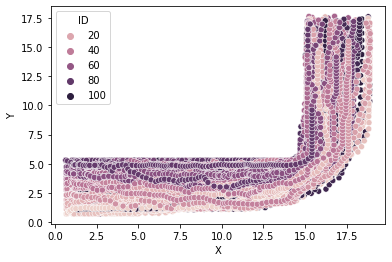

In [9]:
sns.scatterplot(x="X", y="Y", hue="ID", data=left_turn_data)

In [10]:
left_turn_data.describe()

,timestep,ID,X,Y,speed,mean_spacing,0,1,2,3,4,5,6,7,8,9
count,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000
mean,49.436308,50.743983,10.529510,5.726873,0.318832,1.067100,-0.047747,0.047010,-0.016986,-0.005595,-0.017393,-0.036410,-0.021596,-0.023338,0.007304,-0.048269
std,31.425622,28.485462,5.365645,4.128403,0.172096,0.406359,0.578254,0.568333,0.681404,0.696286,0.791459,0.819242,0.893754,0.966702,1.004720,1.106126
min,1.000000,1.000000,0.658963,0.695549,0.000000,0.352109,-1.898057,-2.339627,-2.409784,-2.612260,-2.656438,-3.337474,-3.537792,-4.137736,-3.647777,-5.356890
25%,23.000000,26.000000,5.695077,2.995150,0.189327,0.794363,-0.514610,-0.410405,-0.576432,-0.530466,-0.652622,-0.645655,-0.716128,-0.737544,-0.775055,-0.826432
50%,46.000000,51.000000,11.400298,4.451403,0.303898,0.967412,-0.038985,0.037490,0.000000,0.000000,-0.000425,-0.021093,-0.004418,-0.006356,0.008030,-0.043214
75%,72.000000,74.000000,15.265651,6.888390,0.461228,1.294854,0.419007,0.492250,0.556181,0.528578,0.626681,0.578550,0.706463,0.718012,0.812528,0.784297
max,131.000000,100.000000,18.892999,17.636576,0.767019,4.266354,1.889852,3.631569,2.016391,3.934031,2.793943,4.096822,2.673307,4.707178,3.477924,4.767048


In [11]:
print(left_turn_data.dtypes)

timestep          int64
ID                int64
X               float64
Y               float64
speed           float64
mean_spacing    float64
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
dtype: object


In [12]:
X = left_turn_data[[ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = left_turn_data["speed"]

X

,0,1,2,3,4,5,6,7,8,9,mean_spacing
0,0.000000,0.402000,0.402000,0.000000,0.402000,0.402000,0.804000,0.000000,0.000000,0.804000,0.596103
1,0.402000,0.000000,0.000000,0.402000,-0.402000,0.000000,0.402000,0.402000,-0.402000,0.402000,0.468606
2,0.402000,0.000000,-0.402000,0.000000,0.000000,0.402000,-0.402000,0.402000,0.402000,0.402000,0.468606
3,-0.402000,0.000000,0.000000,0.402000,0.402000,0.000000,-0.402000,0.402000,0.402000,0.402000,0.468606
4,0.000000,0.402000,0.402000,0.000000,-0.402000,0.000000,0.402000,0.402000,-0.402000,0.402000,0.468606
...,...,...,...,...,...,...,...,...,...,...,...
8803,-0.103965,1.075609,1.256176,0.223216,0.575510,1.275931,1.640166,0.918316,2.387252,-0.053762,1.604760
8804,0.513671,-1.615215,-1.779001,-0.133460,-1.278117,-2.605149,-0.213461,-2.962764,-1.957592,-2.805471,2.554420
8805,-0.383989,-0.695100,-1.064656,0.357616,0.747086,-0.972078,0.727132,1.347550,-1.744131,0.157293,1.285129
8806,1.779001,0.133460,0.500884,-2.471689,-0.178591,-2.672011,2.292673,-1.481754,1.565540,-2.829304,2.589456


In [13]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score ,KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

Average MSE: 0.6398197449551544
Test MSE: 0.6279429192066117


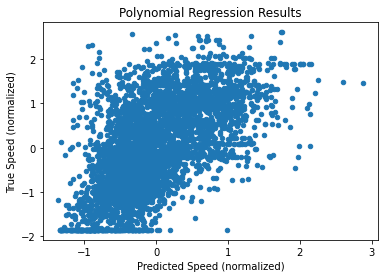

In [16]:
# Split the data into features (X) and target (y)

X = left_turn_data[[ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = left_turn_data["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

"""
# normalize the input (X) and output (y) separately using StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))
"""
# create a pipeline that combines normalization and regression
model = Pipeline([
  ('poly', PolynomialFeatures(degree=2)),
  ('regression', LinearRegression())
])

# use KFold cross-validation to evaluate the model
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
scores = []
for train_index, val_index in kfold.split(X_train):
  X_train_fold, X_val = X_train[train_index], X_train[val_index]
  y_train_fold, y_val = y_train[train_index], y_train[val_index]

  # fit the model to the training data
  model.fit(X_train_fold, y_train_fold)

  # evaluate the model on the validation data
  y_val_pred = model.predict(X_val)
  score = mean_squared_error(y_val, y_val_pred)
  scores.append(score)

# print the average mean squared error across the 5 folds
print("Average MSE:", np.mean(scores))

# evaluate the model on the test data
y_test_pred = model.predict(X_test)
test_score = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_score)

# plot the regression results
plt.scatter(y_test_pred, y_test, s=20)
plt.xlabel("Predicted Speed (normalized)")
plt.ylabel("True Speed (normalized)")
plt.title("Polynomial Regression Results")
plt.show()

In [17]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample

In [19]:
# Create separate arrays for input (X) and output (y)
X = left_turn_data[[ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = left_turn_data["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Initialize a list to store the training, validation, and testing losses
training_losses = []
validation_losses = []
testing_losses = []

# Define the number of folds for the cross validation
n_folds = 5

# Initialize the KFold object for cross validation
kf = KFold(n_folds)

# Define the number of subsamples for the bootstrapping
n_subsamples = 35

# Loop over the subsamples
for i in range(n_subsamples):
    # Bootstrap the training data
    X_train_sub, y_train_sub = resample(X_train, y_train, random_state=i)
    print("We are in subsample:{} out of 50".format(i))
    
    # Loop over the folds for cross validation
    for train_index, val_index in kf.split(X_train_sub):
        X_train_cv, X_val = X_train_sub[train_index], X_train_sub[val_index]
        y_train_cv, y_val = y_train_sub[train_index], y_train_sub[val_index]
        
        # Build the model
        with tf.device('/GPU:0'):
          model = Sequential()
          model.add(Dense(units = 3, activation='relu', input_shape=(X_train_cv.shape[1],)))
          model.add(Dense(1))
          model.compile(optimizer='adam', loss='mean_squared_error')

        # Add Early stopping in case the model overfits
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        
        # Train the model on the training data
        with tf.device('/GPU:0'):
          history = model.fit(X_train_cv, y_train_cv, epochs=75, verbose=1,validation_data=(X_val, y_val), callbacks=[early_stopping])
    
        # Evaluate the model on the validation data
        with tf.device('/GPU:0'):
          val_loss = model.evaluate(X_val, y_val, verbose=1)
          validation_losses.append(val_loss)
        
        # Evaluate the model on the testing data
        with tf.device('/GPU:0'):
          test_loss = model.evaluate(X_test, y_test, verbose=1)
          testing_losses.append(test_loss)
#Calculate the mean and standard deviation of the training loss

mean_training_loss = np.mean(history.history['loss'])
std_training_loss = np.std(history.history['loss'])
training_losses.append((mean_training_loss, std_training_loss))

#Calculate the mean and standard deviation of the validation losses

mean_validation_loss = np.mean(validation_losses)
std_validation_loss = np.std(validation_losses)

#Calculate the mean and standard deviation of the testing losses
mean_testing_loss = np.mean(testing_losses)
std_testing_loss = np.std(testing_losses)

print("Mean training loss: {:.4f} +/- {:.4f}".format(mean_training_loss, std_training_loss))
print("Mean validation loss: {:.4f} +/- {:.4f}".format(mean_validation_loss, std_validation_loss))
print("Mean testing loss: {:.4f} +/- {:.4f}".format(mean_testing_loss, std_testing_loss))

Streaming output truncated to the last 5000 lines.
Epoch 56/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6451 - val_loss: 0.6821
Epoch 57/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6449 - val_loss: 0.6805
Epoch 58/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6441 - val_loss: 0.6801
Epoch 59/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6431 - val_loss: 0.6793
Epoch 60/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6426 - val_loss: 0.6781
Epoch 61/75
111/111 [==============================] - 0s 4ms/step - loss: 0.6419 - val_loss: 0.6770
Epoch 62/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6415 - val_loss: 0.6765
Epoch 63/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6411 - val_loss: 0.6747
Epoch 64/75
111/111 [==============================] - 0s 3ms/step - loss: 0.6395 - val_loss: 0.6732
Epoch 65/75
111/111 [===================

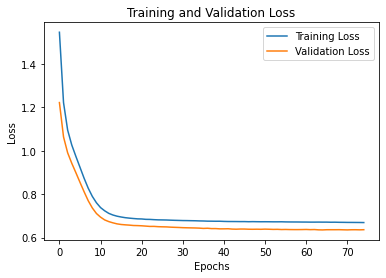

138/138 [==============================] - 0s 1ms/step


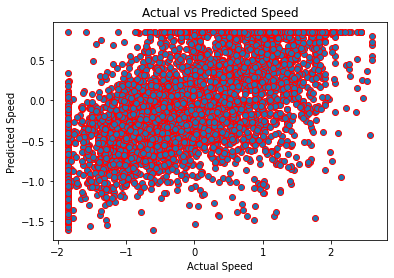

138/138 [==============================] - 0s 1ms/step


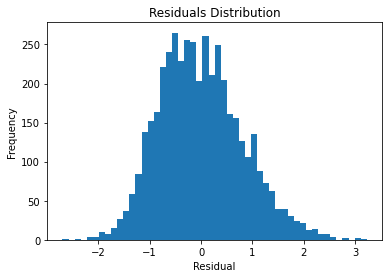

In [20]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



# Plot the actual vs predicted speeds
plt.scatter(y_test, model.predict(X_test), edgecolors='r')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs Predicted Speed')
plt.show()

# Plot the residuals
residuals = y_test - model.predict(X_test)
plt.hist(residuals, bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

In [21]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

## Optional: Perform Hyperparameter tuning using Grid Search for finding the best parameters

In [25]:
#from hyperparameter_tuning
#run_hyperparameter_tuning(X_train,y_train)